# SUHII Calculation with LCZ and LST rasters

**Dependencies**

In [167]:
import rasterio
import rioxarray as rio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from rasterio.warp import reproject, Resampling
import seaborn as sns
import os
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

In [159]:
NOTEBOOK_DIRECTORY = pathlib.Path().resolve()
OUTPUT_DIRECTORY = NOTEBOOK_DIRECTORY / "output" / "SUHII"
PLOT_DIRECTORY = NOTEBOOK_DIRECTORY / "output" / "plots"

## File Paths

### LCZ

In [160]:
# full extent
LCZ_2014_path = '/Users/moritzmuhlbauer/Master Thesis/output/LCZ/2014/v6/LCZ_2014_v6_3301.tif'
LCZ_2022_path = '/Users/moritzmuhlbauer/Master Thesis/output/LCZ/2022/v1/LCZ_2022_v1_3301.tif'

In [161]:
# clippped to Tallinn municipality borders
LCZ_2014_clipped_path = '/Users/moritzmuhlbauer/Master Thesis/output/LCZ/2014/v6/LCZ_2014_v6_3301_clipped.tif'
LCZ_2022_clipped_path = '/Users/moritzmuhlbauer/Master Thesis/output/LCZ/2022/v1/LCZ_2022_v1_3301_clipped.tif'

### LST

In [162]:
# 2014 #

# heatwave 
LST_2014_07_25_hw_path = '/Users/moritzmuhlbauer/Master Thesis/output/SUHII/LST/2014/LST_2014_07_25_hw.tif'
# no heatwave
LST_2014_05_22_nhw_path = '/Users/moritzmuhlbauer/Master Thesis/output/SUHII/LST/2014/LST_2014_05_22_nhw.tif'

# 2022 # 

# heatwave
LST_2022_08_16_hw_path = '/Users/moritzmuhlbauer/Master Thesis/output/SUHII/LST/2022/LST_2022_08_16_hw.tif'
# no heatwave
LST_2022_05_21_nhw_path = '/Users/moritzmuhlbauer/Master Thesis/output/SUHII/LST/2022/LST_2022_05_21_nhw.tif'

## Helper Functions

In [163]:
def align_rasters(lcz_path, lst_path, band=2):
    with rasterio.open(lcz_path) as lcz_src:
        lcz = lcz_src.read(band)
        lcz_meta = lcz_src.meta.copy()
        lcz_nodata = lcz_src.nodata

    with rasterio.open(lst_path) as lst_src:
        lst_nodata = lst_src.nodata

        lst_aligned = np.empty_like(lcz, dtype=lst_src.meta['dtype'])

        reproject(
            source=rasterio.band(lst_src, 1),
            destination=lst_aligned,
            src_transform=lst_src.transform,
            src_crs=lst_src.crs,
            dst_transform=lcz_meta['transform'],
            dst_crs=lcz_meta['crs'],
            dst_resolution=(lcz_meta['transform'][0], -lcz_meta['transform'][4]),  # ensuring matching resolution
            resampling=Resampling.bilinear,  # using bilinear for LST (continuous data)
            src_nodata=lst_nodata,
            dst_nodata=lst_nodata
        )

    return lcz, lst_aligned, lcz_meta, lcz_nodata, lst_nodata

In [164]:
def calculate_SUHII(LCZ, LST, nodata_lcz=None, nodata_lst=None, lcz_d_code=14):
    
    # creating a mask of valid data
    mask = (~np.isnan(LST)) & (~np.isnan(LCZ))
    if nodata_lst is not None:
        mask &= (LST != nodata_lst)
    if nodata_lcz is not None:
        mask &= (LCZ != nodata_lcz)

    # Also exclude LCZ == 0
    mask &= (LCZ != 0)

    # Flatten for DataFrame
    df = pd.DataFrame({
        'LCZ': LCZ[mask].astype(int),
        'LST': LST[mask]
    })

    mean_lst = df.groupby('LCZ')['LST'].mean()
    mean_d = mean_lst[lcz_d_code]

    SUHII = np.full_like(LST, np.nan, dtype=np.float32)
    for lcz_class in mean_lst.index:
        SUHII[LCZ == lcz_class] = mean_lst[lcz_class] - mean_d

    return SUHII, mean_lst, mean_d, mask

In [165]:
def export_SUHII(raster, name, metadata, output_dir):
    output_path = output_dir / name

    with rasterio.open(output_path, "w", **metadata) as dst:
        dst.write(raster, 1)

In [166]:
def mask_nodata(array, nodata_value):
    array = array.astype(np.float32)  # important for np.nan support
    array[array == nodata_value] = np.nan
    return array

In [10]:
def plot_LST_by_LCZ(LCZ, LST, lcz_nodata, lst_nodata, title, file_name):
    # Convert nodata to np.nan
    LCZ = LCZ.astype(np.float32)
    LST = LST.astype(np.float32)
    LCZ[LCZ == lcz_nodata] = np.nan
    LST[LST == lst_nodata] = np.nan

    # Mask valid data
    mask = np.isfinite(LCZ) & np.isfinite(LST)

    # Flatten and create DataFrame
    df = pd.DataFrame({
        'LCZ': LCZ[mask].astype(int),
        'LST': LST[mask]
    })

    # Filter to unique LCZs only
    present_lczs = sorted(df['LCZ'].unique())
    if 0 in present_lczs:
        present_lczs.remove(0)

    # Define official WUDAPT color palette for LCZ classes 1–10, A–G
    lcz_colors = {
        1: "#8C0000", 2: "#D10000", 3: "#ff7f50",
        4: "#BF4D00", 5: "#FF6600", 6: "#fdae61",
        7: "#fee08b", 8: "#BCBCBC", 9: "#FFCCAA", 10: "#555555",
        11: "#006A00", 12: "#00AA00", 13: "#648525",
        14: "#B9DB79", 15: "#000000", 16: "#FBF7AE", 17: "#6A6AFF"
    }

    # Extract only present colors
    palette = [lcz_colors[lcz] for lcz in present_lczs]

    # Convert to ordered categorical
    df['LCZ'] = pd.Categorical(df['LCZ'], categories=present_lczs, ordered=True)

    # Plot
    plt.figure(figsize=(15, 10))
    ax = sns.boxplot(data=df, x='LCZ', y='LST', order=present_lczs, palette=palette, fliersize=1)

    # Add median line
    overall_median = df['LST'].median()

    # Annotate
    std = df['LST'].std()
    plt.text(0.015, 0.1, f'std = {std:.1f}°C\nmedian = {overall_median:.1f}°C',
             transform=ax.transAxes, verticalalignment='top', fontsize=12, fontname='Times New Roman',
             bbox=dict(boxstyle="round", fc="white", ec="gray"))

    # Labels
    plt.ylabel('LST (°C)', fontsize=12, fontname='Times New Roman')
    plt.xlabel('LCZ class', fontsize=12, fontname='Times New Roman')
    plt.title(f'{title}\n', fontsize=20, fontname='Times New Roman')

    plt.ylim(0, 55)

    plt.savefig(os.path.join(PLOT_DIRECTORY, file_name), dpi=600)
    
    plt.tight_layout()
    plt.show()

In [11]:
def calculate_lcz_areas(lcz_path, class_range=range(1, 11)):
    with rasterio.open(lcz_path) as src:
        lcz = src.read(1)
        transform = src.transform
        pixel_area = abs(transform.a * transform.e)
        nodata = src.nodata

    if nodata is not None:
        lcz = lcz[lcz != nodata]

    mask = np.isin(lcz, class_range)
    lcz_filtered = lcz[mask]

    unique, counts = np.unique(lcz_filtered, return_counts=True)
    areas_km2 = counts * pixel_area / 1e6

    return dict(zip(unique, areas_km2))

In [190]:
def plot_lcz_comparison_colored(area_2014, area_2022, title, area_sum_2014, area_sum_2022, file_name):
    
    classes_present = sorted(set(area_2014.keys()).union(set(area_2022.keys())))
    labels = [LCZ_LABELS.get(c, f"LCZ {c}") for c in classes_present]

    areas_2014 = [area_2014.get(c, 0) for c in classes_present]
    areas_2022 = [area_2022.get(c, 0) for c in classes_present]

    x = np.arange(len(classes_present))
    width = 0.35
    font_props = FontProperties(family='Times New Roman', size=18)

    fig, ax = plt.subplots(figsize=(15, 10))

    # Colors based on LCZ standard; apply hatch to 2022
    colors = [LCZ_COLORS[c] for c in classes_present]

    bars1 = ax.bar(x - width/2, areas_2014, width, label='2014', color=colors)
    bars2 = ax.bar(x + width/2, areas_2022, width, label='2022', color=colors, hatch='//', edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14, fontname='Times New Roman')
    ax.set_xlabel("LCZ (Urban)", fontsize=18, fontname='Times New Roman')
    ax.set_ylabel("Area (km²)", fontsize=18, fontname='Times New Roman')
    custom_legend = [
    Patch(facecolor='white', edgecolor='black', label=f'2014, total area: {area_sum_2014} km2'),
    Patch(facecolor='white', edgecolor='black', hatch='//', label=f'2022, total area: {area_sum_2022} km2')
    ]
    
    
    ax.legend(handles=custom_legend, prop=font_props)

    #ax.legend(handles=custom_legend)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    plt.savefig(os.path.join(PLOT_DIRECTORY, f"{file_name}"), dpi=600)
    
    plt.show()

In [13]:
def calculate_suhi_area_by_class(suhi_path, pixel_area_km2=0.0009):
    """
    Calculate SUHI area in km² for defined intensity ranges from a raster file.

    Intensity classes:
    1. (0–2]
    2. (2–4]
    3. (4–6]
    4. (6–8]
    5. >8

    Parameters:
    - suhi_path (str): Path to SUHI raster file
    - pixel_area_km2 (float): Area of a single pixel in km²

    Returns:
    - dict: Area in km² for each SUHI intensity class
    """
    with rasterio.open(suhi_path) as src:
        suhi_array = src.read(1)
        nodata = src.nodata

    # Mask out nodata values
    if nodata is not None:
        suhi_array = suhi_array.astype(np.float32)
        suhi_array[suhi_array == nodata] = np.nan

    classes = {
        "1: >0–2": (suhi_array > 0) & (suhi_array <= 2),
        "2: >2–4": (suhi_array > 2) & (suhi_array <= 4),
        "3: >4–6": (suhi_array > 4) & (suhi_array <= 6),
        "4: >6–8": (suhi_array > 6) & (suhi_array <= 8),
        "5: >8": (suhi_array > 8)
    }

    area_by_class = {
        label: np.sum(mask) * pixel_area_km2
        for label, mask in classes.items()
    }

    return area_by_class

In [179]:
def plot_LST_by_LCZ_2x2(
    LCZ_2014, LST_2014_hw, LST_2014_nhw,
    LCZ_2022, LST_2022_hw, LST_2022_nhw,
    lcz_nodata_2014, lst_nodata_2014_hw, lst_nodata_2014_nhw,
    lcz_nodata_2022, lst_nodata_2022_hw, lst_nodata_2022_nhw,
    air_temps
):
    fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharey=True)
    axes = axes.flatten()

    # Define WUDAPT LCZ color palette
    lcz_colors = {
        1: "#8C0000", 2: "#D10000", 3: "#ff7f50",
        4: "#BF4D00", 5: "#FF6600", 6: "#fdae61",
        7: "#fee08b", 8: "#BCBCBC", 9: "#FFCCAA", 10: "#555555",
        11: "#006A00", 12: "#00AA00", 13: "#648525",
        14: "#B9DB79", 15: "#000000", 16: "#FBF7AE", 17: "#6A6AFF"
    }

    datasets = [
        ('2014-07-25 heatwave', LCZ_2014, LST_2014_hw, lcz_nodata_2014, lst_nodata_2014_hw, air_temps['2014_hw']),
        ('2014-05-22 no heatwave', LCZ_2014, LST_2014_nhw, lcz_nodata_2014, lst_nodata_2014_nhw, air_temps['2014_nhw']),
        ('2022-08-16 heatwave', LCZ_2022, LST_2022_hw, lcz_nodata_2022, lst_nodata_2022_hw, air_temps['2022_hw']),
        ('2022-05-21 no heatwave', LCZ_2022, LST_2022_nhw, lcz_nodata_2022, lst_nodata_2022_nhw, air_temps['2022_nhw']),
    ]

    for i, (title, LCZ, LST, lcz_nodata, lst_nodata, max_temp) in enumerate(datasets):
        LCZ = LCZ.astype(np.float32)
        LST = LST.astype(np.float32)
        LCZ[LCZ == lcz_nodata] = np.nan
        LST[LST == lst_nodata] = np.nan
        mask = np.isfinite(LCZ) & np.isfinite(LST)

        df = pd.DataFrame({
            'LCZ': LCZ[mask].astype(int),
            'LST': LST[mask]
        })

        present_lczs = sorted(df['LCZ'].unique())
        if 0 in present_lczs:
            present_lczs.remove(0)

        palette = [lcz_colors[lcz] for lcz in present_lczs]
        df['LCZ'] = pd.Categorical(df['LCZ'], categories=present_lczs, ordered=True)

        ax = axes[i]
        sns.boxplot(data=df, x='LCZ', y='LST', order=present_lczs, palette=palette, fliersize=1, ax=ax)

        std = df['LST'].std()
        median = df['LST'].median()

        ax.text(0.02, 0.15,
                f'std = {std:.1f}°C\nmedian = {median:.1f}°C\nmax daily air temp = {max_temp}°C',
                transform=ax.transAxes,
                verticalalignment='top',
                fontsize=12,
                fontname='Times New Roman',
                bbox=dict(boxstyle="round", fc="white", ec="gray"))

        ax.set_title(f"\n{title}\n", fontsize=18, fontname='Times New Roman')
               # Map LCZ tick labels: 1–10 stay as-is, 11–17 become A–G
        tick_labels = []
        for lcz in present_lczs:
            if 1 <= lcz <= 10:
                tick_labels.append(str(lcz))
            elif 11 <= lcz <= 17:
                tick_labels.append(chr(ord('A') + (lcz - 11)))
            else:
                tick_labels.append(str(lcz))  # fallback for safety

        ax.set_xticklabels(tick_labels, fontname='Times New Roman')

        ax.set_ylim(-2, 55)
        ax.set_xticklabels(ax.get_xticklabels())

        ax.set_xlabel('')
        ax.set_ylabel('')


    fig.text(0.5, 0.07, 'LCZ', ha='center', fontsize=14, fontname='Times New Roman')
    fig.text(0.09, 0.5, 'LST (°C)', va='center', rotation='vertical', fontsize=14, fontname='Times New Roman')

    plt.savefig('/Users/moritzmuhlbauer/Master Thesis/output/plots/LST_LCZ_4x4.jpg',
            dpi=600, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

## Data Import and Alignment

In [14]:
# 2014 #

# heatwave
LCZ_2014, LST_2014_07_25_hw, meta_2014_07_25_hw, lcz_nodata_2014, lst_nodata_2014_07_25_hw = align_rasters(LCZ_2014_path, LST_2014_07_25_hw_path)

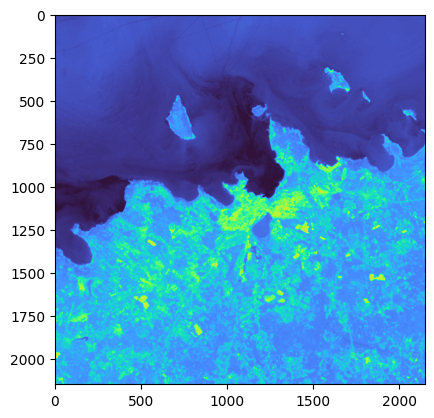

In [15]:
plt.imshow(LST_2014_07_25_hw, cmap='turbo', vmin=20, vmax=65)

In [16]:
# no heatwave

LCZ_2014, LST_2014_05_22_nhw, meta_2014_05_22_nhw, lcz_nodata_2014, lst_nodata_2014_05_22_nhw = align_rasters(LCZ_2014_path, LST_2014_05_22_nhw_path)

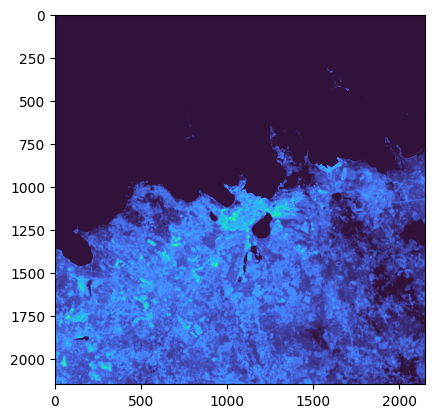

In [17]:
plt.imshow(LST_2014_05_22_nhw, cmap='turbo', vmin=20, vmax=65)

---

In [18]:
# 2022 #

# heatwave
LCZ_2022, LST_2022_08_16_hw, meta_2022_08_16_hw, lcz_nodata_2022, lst_nodata_2022_08_16_hw = align_rasters(LCZ_2022_path, LST_2022_08_16_hw_path)

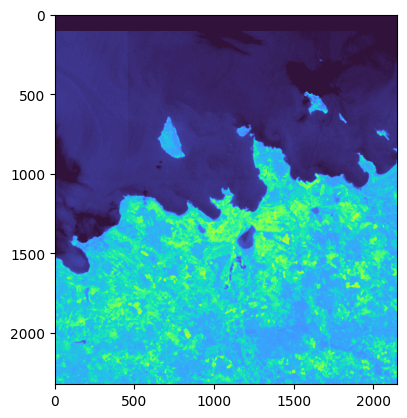

In [19]:
plt.imshow(LST_2022_08_16_hw, cmap='turbo', vmin=20, vmax=65)

In [20]:
# 2022 #

# no heatwave
LCZ_2022, LST_2022_05_21_nhw, meta_2022_05_21_nhw, lcz_nodata_2022, lst_nodata_2022_05_21_nhw = align_rasters(LCZ_2022_path, LST_2022_05_21_nhw_path)


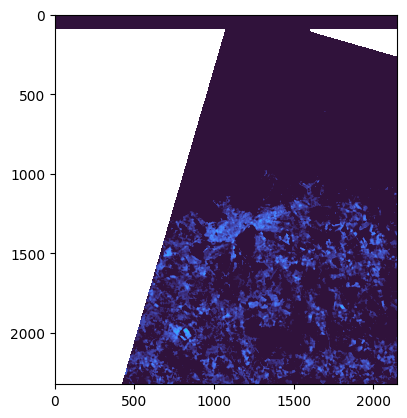

In [21]:
plt.imshow(LST_2022_05_21_nhw, cmap='turbo', vmin=20, vmax=65)

## SUHII calculation

### 2014

In [22]:
# heatwave
SUHII_2014_07_25_hw, mean_lst_2014_07_25_hw, mean_d_2014_07_25_hw, mask_2014_07_25_hw = calculate_SUHII(LCZ_2014, LST_2014_07_25_hw, lcz_nodata_2014, lst_nodata_2014_07_25_hw, lcz_d_code=14)

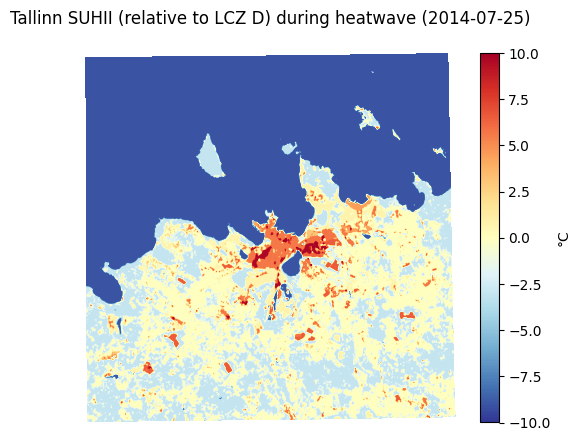

In [23]:
plt.imshow(SUHII_2014_07_25_hw, cmap='RdYlBu_r', vmin=-10, vmax=10)
plt.colorbar(label="°C")
plt.title(f"Tallinn SUHII (relative to LCZ D) during heatwave (2014-07-25)\n")
plt.axis("off")
plt.show()

In [24]:
mean_lst_2014_07_25_hw

LCZ
1     40.063873
2     42.555541
4     37.652324
5     37.461953
8     41.533706
9     32.635750
10    36.306042
11    28.887400
12    30.029398
13    34.955737
14    31.880812
15    38.140557
16    38.436055
17    22.892435
Name: LST, dtype: float64

In [25]:
mean_d_2014_07_25_hw

31.88081202768088

In [26]:
# dropping water class for less biased mean values
mean_lst_2014_07_25_hw = mean_lst_2014_07_25_hw.drop(17)

In [27]:
# calcualting daily over all LCZ classed w/o water
mean_daily_2014_07_25_hw = mean_lst_2014_07_25_hw.mean()
mean_daily_2014_07_25_hw

36.195319139692934

---

In [28]:
# no heatwave

SUHII_2014_05_22_nhw, mean_lst_2014_05_22_nhw, mean_d_2014_05_22_nhw, mask_2014_05_22_nhw = calculate_SUHII(LCZ_2014, LST_2014_05_22_nhw, lcz_nodata_2014, lst_nodata_2014_05_22_nhw, lcz_d_code=14)

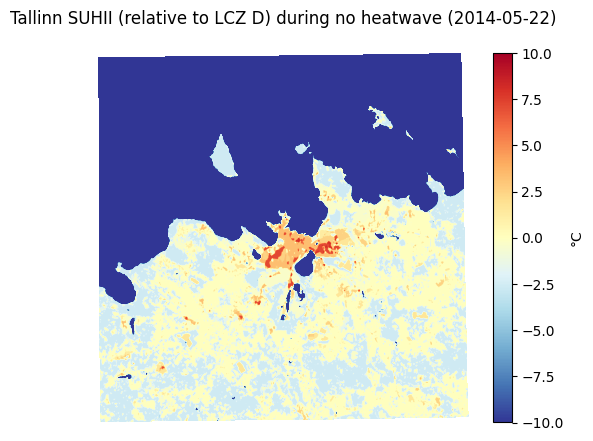

In [29]:
plt.imshow(SUHII_2014_05_22_nhw, cmap='RdYlBu_r', vmin=-10, vmax=10)
plt.colorbar(label="°C")
plt.title(f"Tallinn SUHII (relative to LCZ D) during no heatwave (2014-05-22)\n")
plt.axis("off")
plt.show()

In [30]:
mean_lst_2014_05_22_nhw

LCZ
1     32.140358
2     33.510191
4     28.119757
5     28.835520
8     32.672179
9     25.219141
10    25.205454
11    22.971946
12    24.157110
13    26.773973
14    25.553962
15    28.573233
16    27.168959
17     9.080797
Name: LST, dtype: float64

In [31]:
mean_d_2014_05_22_nhw

25.553962007856928

In [32]:
# dropping water class for less biased mean values
mean_lst_2014_05_22_nhw = mean_lst_2014_05_22_nhw.drop(17)

In [33]:
mean_daily_2014_05_22_nhw = mean_lst_2014_05_22_nhw.mean()
mean_daily_2014_05_22_nhw

27.76167570560577

### 2022

In [34]:
# heatwave
SUHII_2022_08_16_hw, mean_lst_2022_08_16_hw, mean_d_2022_08_16_hw, mask_2022_08_16_hw = calculate_SUHII(LCZ_2022, LST_2022_08_16_hw, lcz_nodata_2022, lst_nodata_2022_08_16_hw, lcz_d_code=14)

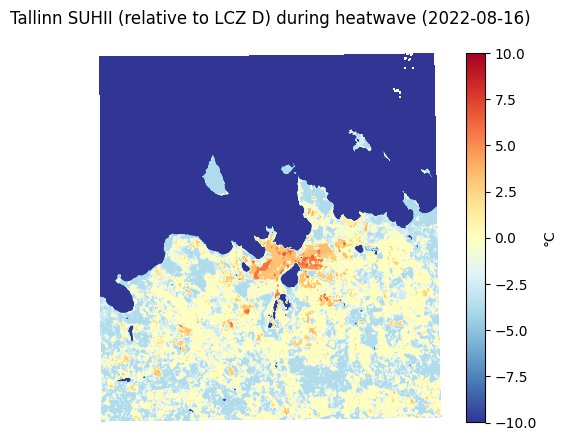

In [35]:
plt.imshow(SUHII_2022_08_16_hw, cmap='RdYlBu_r', vmin=-10, vmax=10)
plt.colorbar(label="°C")
plt.title(f"Tallinn SUHII (relative to LCZ D) during heatwave (2022-08-16)\n")
plt.axis("off")
plt.show()

In [36]:
mean_lst_2022_08_16_hw

LCZ
1     38.115968
2     41.258564
4     37.977288
5     37.720642
8     40.322493
9     34.187258
10    35.649165
11    30.762855
12    31.916720
13    37.271301
14    34.558601
15    39.417722
16    37.293211
17    19.771950
Name: LST, dtype: float64

In [37]:
mean_d_2022_08_16_hw

34.558600512504704

In [38]:
# dropping water class for less biased mean values
mean_lst_2022_08_16_hw = mean_lst_2022_08_16_hw.drop(17)

In [39]:
# calcualting daily over all LCZ classed w/o water
mean_daily_2022_08_16_hw = mean_lst_2022_08_16_hw.mean()
mean_daily_2022_08_16_hw

36.650137535869256

---

In [40]:
# no heatwave
SUHII_2022_05_21_nhw, mean_lst_2022_05_21_nhw, mean_d_2022_05_21_nhw, mask_2022_05_21_nhw = calculate_SUHII(LCZ_2022, LST_2022_05_21_nhw, lcz_nodata_2022, lst_nodata_2022_05_21_nhw, lcz_d_code=14)

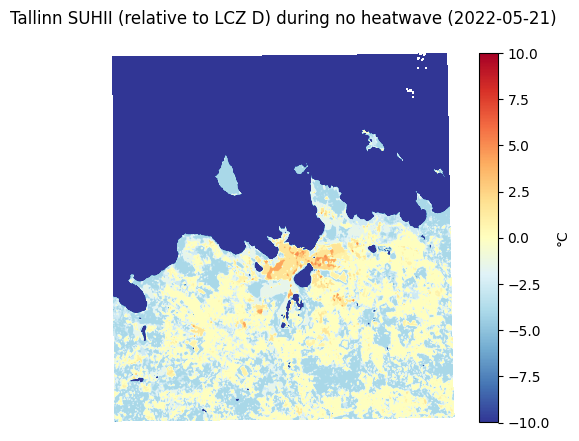

In [41]:
plt.imshow(SUHII_2022_05_21_nhw, cmap='RdYlBu_r', vmin=-10, vmax=10)
plt.colorbar(label="°C")
plt.title(f"Tallinn SUHII (relative to LCZ D) during no heatwave (2022-05-21)\n")
plt.axis("off")
plt.show()

In [42]:
mean_lst_2022_05_21_nhw

LCZ
1     24.657169
2     26.493366
4     23.207144
5     23.229527
8     25.720574
9     19.984456
10    18.900476
11    17.497323
12    18.875292
13    22.019590
14    21.513767
15    23.904263
16    22.425896
17     5.200723
Name: LST, dtype: float64

In [43]:
mean_d_2022_05_21_nhw

21.513766697096063

In [44]:
# dropping water class for less biased mean values
mean_lst_2022_05_21_nhw = mean_lst_2022_05_21_nhw.drop(17)

In [45]:
mean_daily_2022_05_21_nhw = mean_lst_2022_05_21_nhw.mean()
mean_daily_2022_05_21_nhw

22.186834102272922

### SUHII Export

In [46]:
export_SUHII(SUHII_2014_07_25_hw, "SUHII_2014_07_25_hw.tif", meta_2014_07_25_hw, OUTPUT_DIRECTORY)
export_SUHII(SUHII_2022_08_16_hw, "SUHII_2022_08_16_hw.tif", meta_2022_08_16_hw, OUTPUT_DIRECTORY)
export_SUHII(SUHII_2014_05_22_nhw, "SUHII_2014_05_22_nhw.tif", meta_2014_05_22_nhw, OUTPUT_DIRECTORY)
export_SUHII(SUHII_2022_05_21_nhw, "SUHII_2022_05_21_nhw.tif", meta_2022_05_21_nhw, OUTPUT_DIRECTORY)

/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/numpy/core/_asarray.py:126: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


## LCZ/LST Plots

### 2014

In [47]:
# heatwave
LCZ_2014 = mask_nodata(LCZ_2014, lcz_nodata_2014)
LST_2014_07_25_hw = mask_nodata(LST_2014_07_25_hw, lst_nodata_2014_07_25_hw)

In [49]:
# no heatwave
LST_2014_05_22_nhw = mask_nodata(LST_2014_05_22_nhw, lst_nodata_2014_05_22_nhw)

### 2022

In [51]:
# heatwave
LCZ_2022 = mask_nodata(LCZ_2022, lcz_nodata_2022)
LST_2022_08_16_hw = mask_nodata(LST_2022_08_16_hw, lst_nodata_2022_08_16_hw)

In [53]:
# no heatwave
LST_2022_05_21_nhw = mask_nodata(LST_2022_05_21_nhw, lst_nodata_2022_05_21_nhw)

/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/moritzmuhlbauer/micromamba/envs/gee/lib/python3.

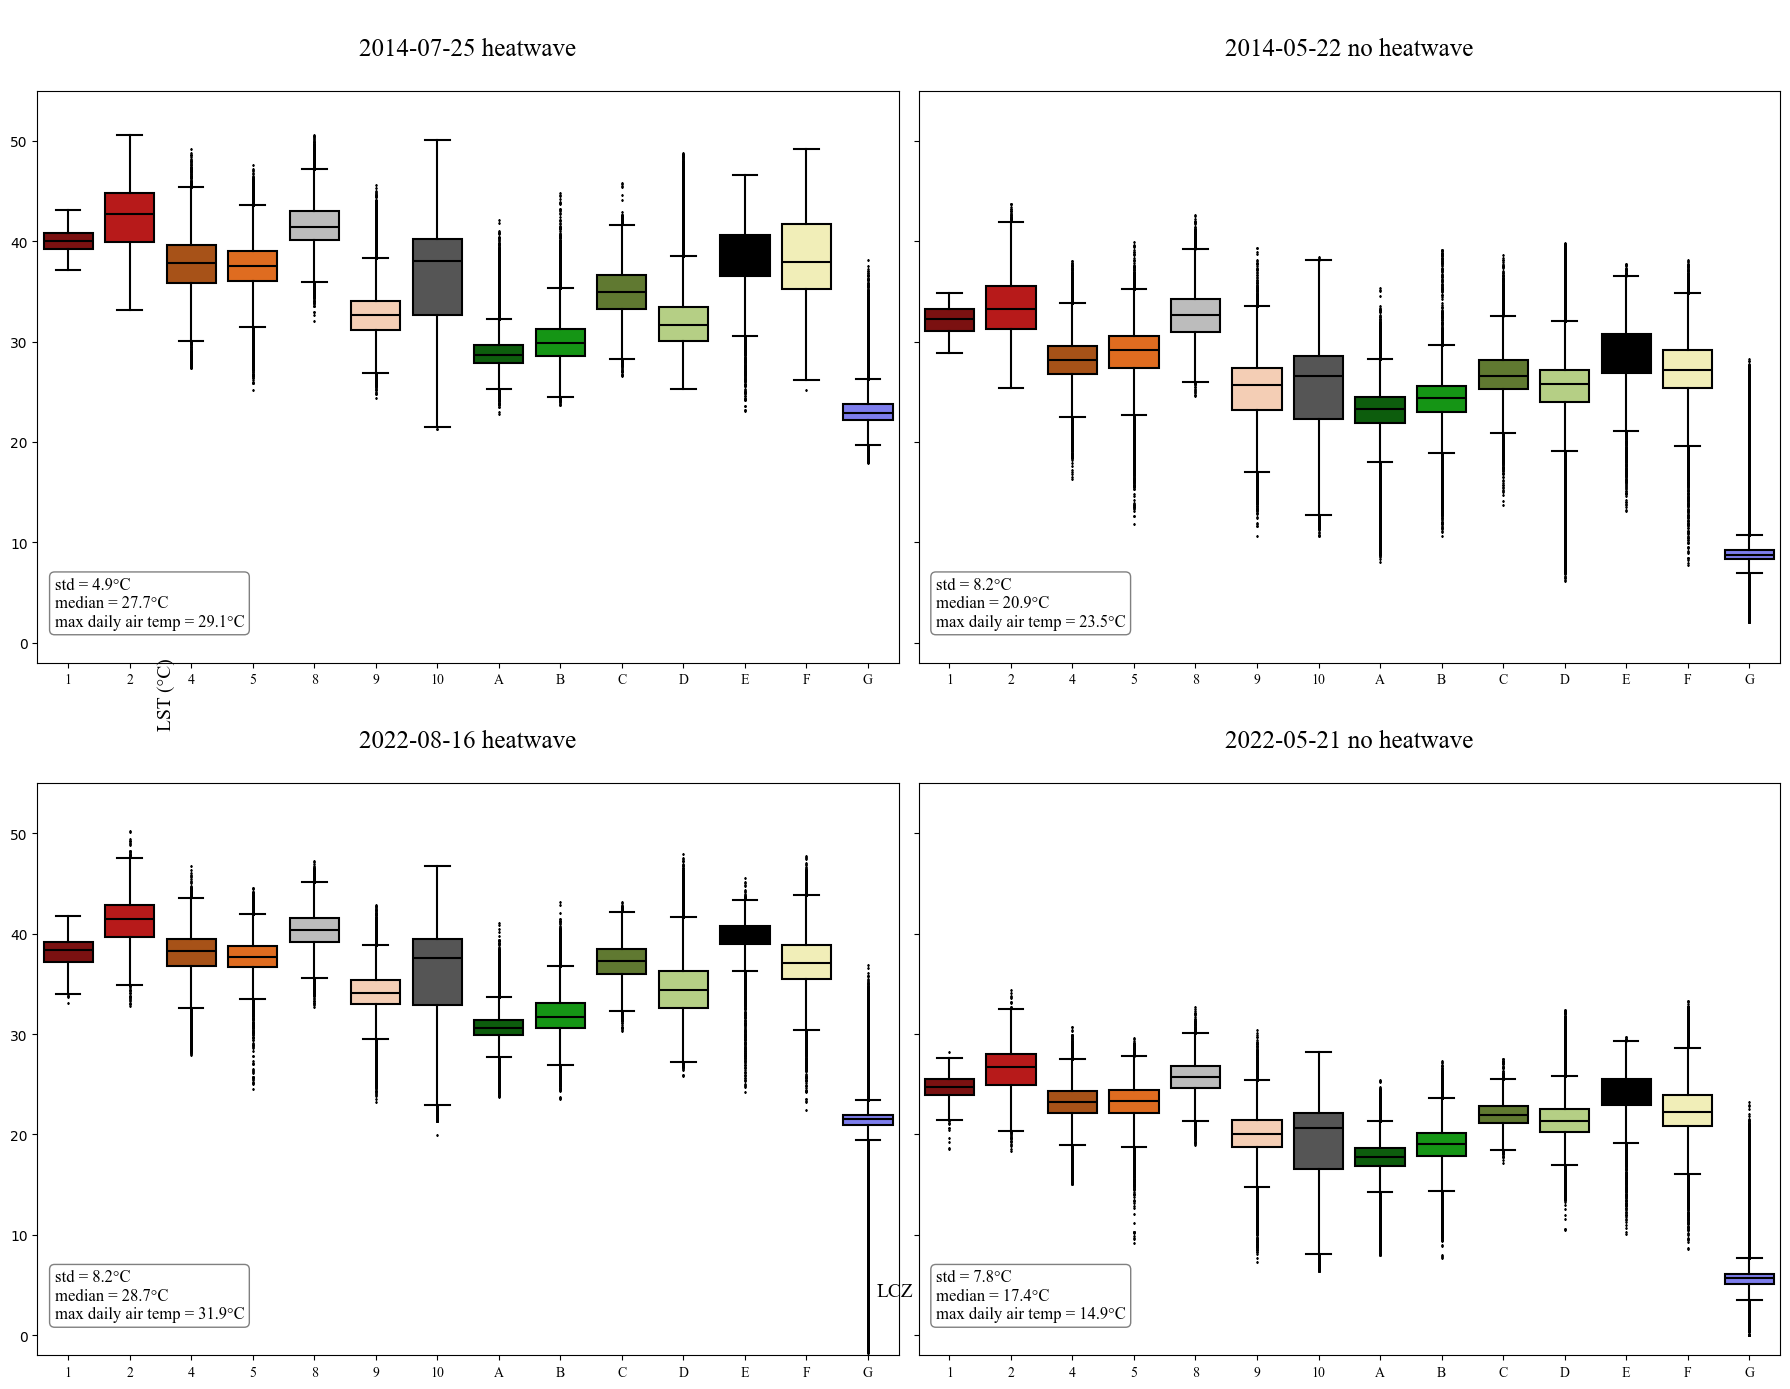

In [180]:
air_temps = {
    '2014_hw': 29.1,        
    '2014_nhw': 23.5,
    '2022_hw': 31.9,
    '2022_nhw': 14.9
}

fig = plot_LST_by_LCZ_2x2(
    LCZ_2014, LST_2014_07_25_hw, LST_2014_05_22_nhw,
    LCZ_2022, LST_2022_08_16_hw, LST_2022_05_21_nhw,
    lcz_nodata_2014, lst_nodata_2014_07_25_hw, lst_nodata_2014_05_22_nhw,
    lcz_nodata_2022, lst_nodata_2022_08_16_hw, lst_nodata_2022_05_21_nhw,
    air_temps
)

## LCZ Area Plot

In [55]:
class_range = [1, 2, 4, 5, 8, 9, 10, 15, 16]

urban_area_2014 = calculate_lcz_areas(LCZ_2014_clipped_path, class_range=class_range)
urban_area_2022 = calculate_lcz_areas(LCZ_2022_clipped_path, class_range=class_range)

In [56]:
urban_area_2014

{1: 0.6183,
 2: 3.2886,
 4: 15.3288,
 5: 28.962,
 8: 12.0816,
 9: 34.2693,
 10: 3.2706,
 15: 3.3633,
 16: 4.1517}

In [57]:
urban_area_2022

{1: 1.5489,
 2: 3.8511,
 4: 15.4602,
 5: 24.7095,
 8: 12.303,
 9: 33.2649,
 10: 3.8556,
 15: 3.5262,
 16: 4.4991}

In [58]:
urban_sum_2014 = sum(urban_area_2014.values()).round(0).astype(int)
urban_sum_2014

105

In [59]:
urban_sum_2022 = sum(urban_area_2022.values()).round(0).astype(int)
urban_sum_2022

103

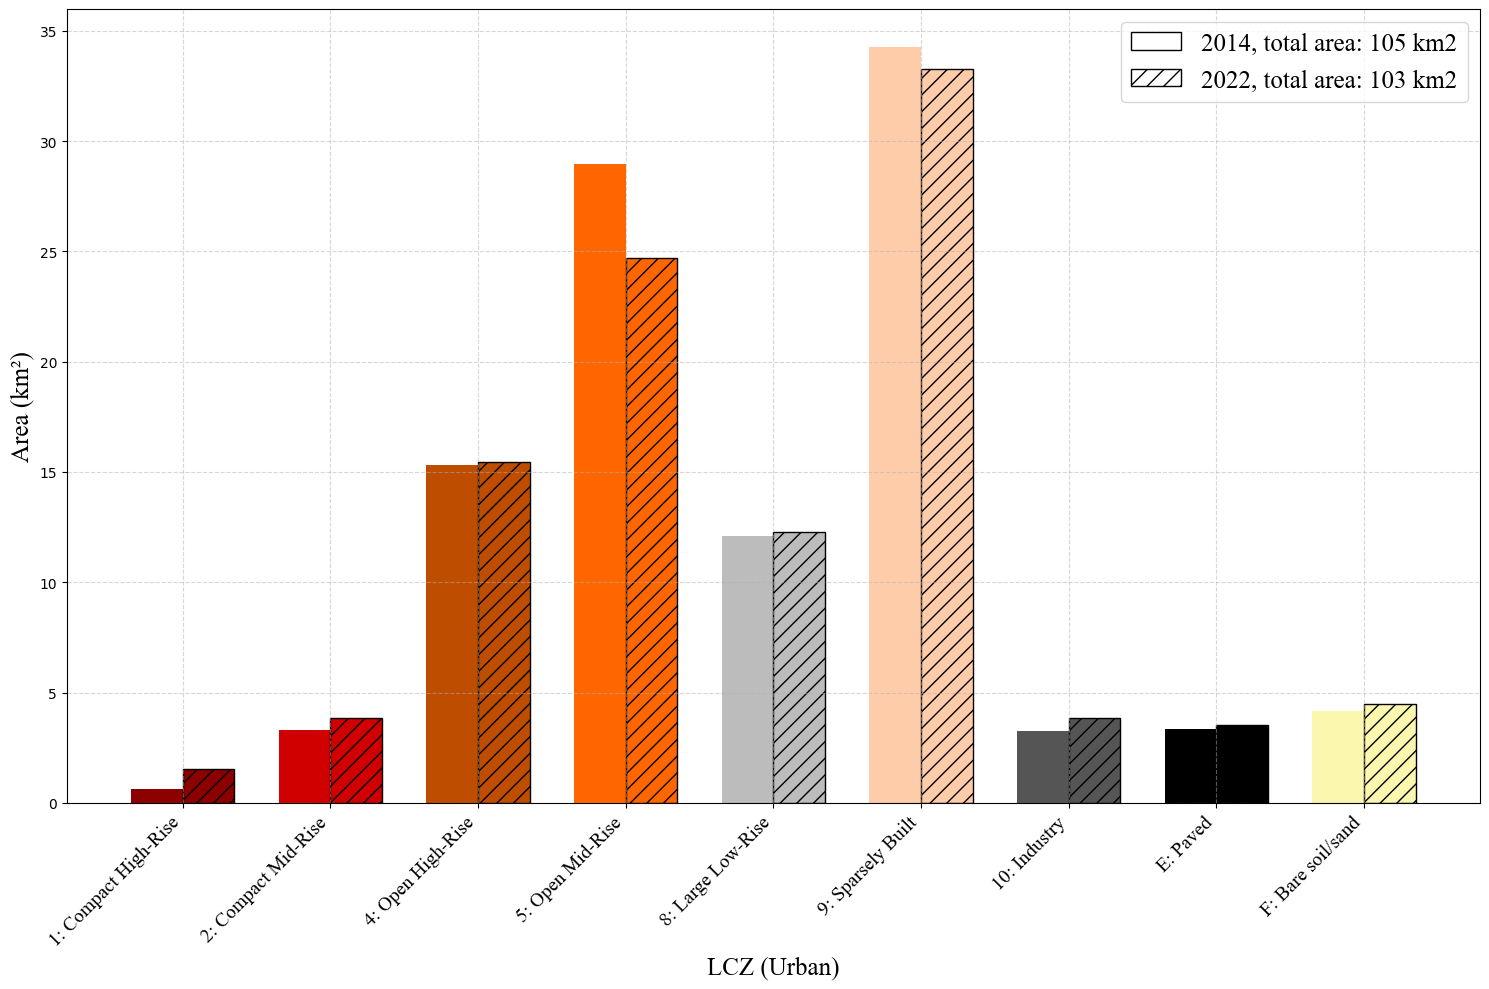

In [191]:
# LCZ standard colors for classes 1–10 (hex codes from LCZ standard)
LCZ_COLORS = {
    1: '#8C0000', 2: '#D10000',
    4: '#BF4D00', 5: '#FF6600',
    8: '#BCBCBC', 9: '#FFCCAA',
    10: '#555555', 15: '#000000', 
    16: '#FBF7AE'
}

LCZ_LABELS = {
    1: "1: Compact High-Rise", 2: "2: Compact Mid-Rise",
    4: "4: Open High-Rise", 5: "5: Open Mid-Rise",
    8: "8: Large Low-Rise", 9: "9: Sparsely Built",
    10: "10: Industry", 15: "E: Paved", 16: 'F: Bare soil/sand'
}

title="Urban LCZ area comparison: 2014 vs 2022"
file_name="LCZ_area_urban"

plot_lcz_comparison_colored(urban_area_2014, urban_area_2022, title, urban_sum_2014, urban_sum_2022, file_name)

## Shifting LCZ

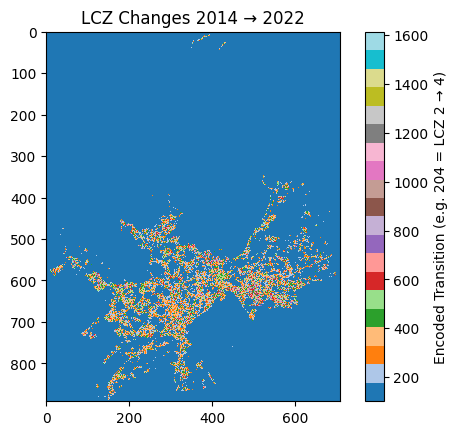

In [67]:
# Classes of interest
valid_classes = {1, 2, 4, 5, 8, 9, 10, 15, 16}

with rasterio.open(LCZ_2014_clipped_path) as src14, rasterio.open(LCZ_2022_clipped_path) as src22:
    lcz_2014 = src14.read(1)
    lcz_2022 = src22.read(1)
    profile = src14.profile

# Mask only valid classes
mask = np.isin(lcz_2014, list(valid_classes)) & np.isin(lcz_2022, list(valid_classes))

# Encode transitions
transitions = (lcz_2014 * 100 + lcz_2022).astype(np.int32)

# Mask unchanged values
changed = (lcz_2014 != lcz_2022) & mask
transitions[~changed] = 0  # or np.nan

# Optional: Save the changed raster
profile.update(dtype='int32', count=1)
with rasterio.open("lcz_changes.tif", 'w', **profile) as dst:
    dst.write(transitions, 1)

# Plot
plt.imshow(transitions, cmap='tab20', vmin=101)
plt.title("LCZ Changes 2014 → 2022")
plt.colorbar(label="Encoded Transition (e.g. 204 = LCZ 2 → 4)")
plt.show()

## SUHI area plots

In [68]:
## Clipped SUHII raster file-paths ##

SUHI_2014_05_22_nhw_clipped_path = '/Users/moritzmuhlbauer/Master Thesis/output/SUHII/SUHII_clipped/SUHII_2014_05_22_nhw_clipped.tif'
SUHI_2014_07_25_hw_clipped_path = '/Users/moritzmuhlbauer/Master Thesis/output/SUHII/SUHII_clipped/SUHII_2014_07_25_hw_clipped.tif'
SUHI_2022_05_21_nhw_clipped_path = '/Users/moritzmuhlbauer/Master Thesis/output/SUHII/SUHII_clipped/SUHII_2022_05_21_nhw_clipped.tif'
SUHI_2022_08_16_hw_clipped_path = '/Users/moritzmuhlbauer/Master Thesis/output/SUHII/SUHII_clipped/SUHII_2022_08_16_hw_clipped.tif'

In [69]:
# conduct processing by calling function
SUHI_area_classes_2014_05_22_nhw = calculate_suhi_area_by_class(SUHI_2014_05_22_nhw_clipped_path)
SUHI_area_classes_2014_07_25_hw = calculate_suhi_area_by_class(SUHI_2014_07_25_hw_clipped_path)
SUHI_area_classes_2022_05_21_nhw = calculate_suhi_area_by_class(SUHI_2022_05_21_nhw_clipped_path)
SUHI_area_classes_2022_08_16_hw = calculate_suhi_area_by_class(SUHI_2022_08_16_hw_clipped_path)

In [70]:
for year, areas in zip(["2014_05_22_nhw", "2014_07_25_hw", "2022_05_21_nhw", "2022_08_16_hw"],\
                       [SUHI_area_classes_2014_05_22_nhw, SUHI_area_classes_2014_07_25_hw,\
                        SUHI_area_classes_2022_05_21_nhw, SUHI_area_classes_2022_08_16_hw]):
    print(f"\nSUHI Intensity Areas for {year}:")
    for intensity, area in areas.items():
        print(f"  {intensity}: {area:.2f} km²")


SUHI Intensity Areas for 2014_05_22_nhw:
  1: >0–2: 21.05 km²
  2: >2–4: 35.20 km²
  3: >4–6: 0.34 km²
  4: >6–8: 13.79 km²
  5: >8: 0.00 km²

SUHI Intensity Areas for 2014_07_25_hw:
  1: >0–2: 0.00 km²
  2: >2–4: 5.54 km²
  3: >4–6: 52.33 km²
  4: >6–8: 0.34 km²
  5: >8: 13.79 km²

SUHI Intensity Areas for 2022_05_21_nhw:
  1: >0–2: 45.34 km²
  2: >2–4: 14.69 km²
  3: >4–6: 0.00 km²
  4: >6–8: 0.00 km²
  5: >8: 0.00 km²

SUHI Intensity Areas for 2022_08_16_hw:
  1: >0–2: 9.58 km²
  2: >2–4: 46.35 km²
  3: >4–6: 13.78 km²
  4: >6–8: 0.00 km²
  5: >8: 0.00 km²


In [71]:
SUHI_area_total_2014_05_22_nhw = sum(SUHI_area_classes_2014_05_22_nhw.values()).round(2)
SUHI_area_total_2014_05_22_nhw

70.38

In [72]:
SUHI_area_total_2014_07_25_hw = sum(SUHI_area_classes_2014_07_25_hw.values()).round(2)
SUHI_area_total_2014_07_25_hw

72.0

In [73]:
SUHI_area_total_2022_05_21_nhw = sum(SUHI_area_classes_2022_05_21_nhw.values()).round(2)
SUHI_area_total_2022_05_21_nhw

60.03

In [74]:
SUHI_area_total_2022_08_16_hw = sum(SUHI_area_classes_2022_08_16_hw.values()).round(2)
SUHI_area_total_2022_08_16_hw

69.71

---

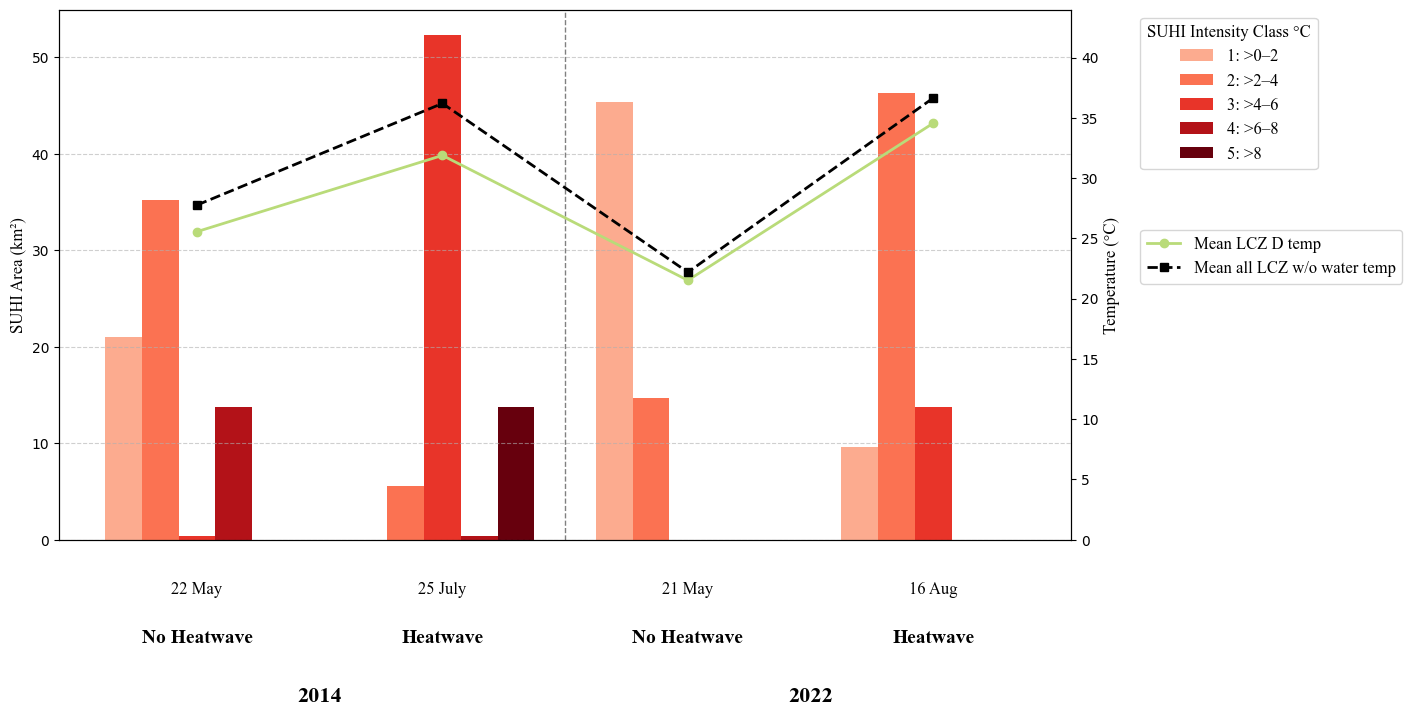

In [178]:
# Define SUHI area results (already calculated using your function)
suhi_grouped = [
    SUHI_area_classes_2014_05_22_nhw,
    SUHI_area_classes_2014_07_25_hw,
    SUHI_area_classes_2022_05_21_nhw,
    SUHI_area_classes_2022_08_16_hw
]

# Time & context labels
events = ["22 May", "25 July", "21 May", "16 Aug"]
years = [2014, 2014, 2022, 2022]
heatwave_status = ["No Heatwave", "Heatwave", "No Heatwave", "Heatwave"]
x = np.arange(len(events))

mean_daily_all_lcz = [
    mean_daily_2014_05_22_nhw,
    mean_daily_2014_07_25_hw,
    mean_daily_2022_05_21_nhw,
    mean_daily_2022_08_16_hw
]
mean_temps = [
    mean_d_2014_05_22_nhw,
    mean_d_2014_07_25_hw,
    mean_d_2022_05_21_nhw,
    mean_d_2022_08_16_hw
]

font_props = FontProperties(family='Times New Roman', size=12)

# Intensity classes (must match your SUHI dict keys)
intensity_classes = list(suhi_grouped[0].keys())
n_classes = len(intensity_classes)

# Build per-class SUHI area values
suhi_area_by_class = {
    cls: [group.get(cls, 0) for group in suhi_grouped]
    for cls in intensity_classes
}

# Color & bar positioning
reds = plt.colormaps["Reds"]
color_bins = [reds(0.3 + 0.7 * i / (n_classes - 1)) for i in range(n_classes)]
bar_width = 0.15
offsets = np.linspace(-bar_width * (n_classes - 1) / 2,
                      bar_width * (n_classes - 1) / 2,
                      n_classes)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(15, 10))

# Grouped bars
for i, cls in enumerate(intensity_classes):
    bar_positions = x + offsets[i]
    ax1.bar(bar_positions, suhi_area_by_class[cls], width=bar_width,
            label=cls, color=[color_bins[i]] * len(x))

# Left Y-axis: SUHI area
ax1.set_ylabel("SUHI Area (km²)", color="black", fontsize=12, fontname='Times New Roman')
ax1.tick_params(axis='y', colors="black")
ax1.spines['left'].set_color("black")
ax1.yaxis.label.set_color("black")

# Right Y-axis: LCZ temperatures
ax2 = ax1.twinx()
ax2.plot(x, mean_temps, color="#B9DB79", marker='o', linewidth=2, label="Mean LCZ D temp")
ax2.plot(x, mean_daily_all_lcz, color="black", marker='s', linewidth=2, linestyle='--', label="Mean all LCZ w/o water temp")
ax2.set_ylabel("Temperature (°C)", color="black", fontsize=12, fontname='Times New Roman')
ax2.tick_params(axis='y', colors="black")
ax2.spines['right'].set_color("black")
ax2.yaxis.label.set_color("black")
ax2.set_ylim(0, max(mean_temps + mean_daily_all_lcz) * 1.2)

# Remove default x-ticks
ax1.set_xticks([])

# --- Custom x-axis labeling ---

# 3rd layer: event dates
for i, xpos in enumerate(x):
    ax1.text(xpos, -0.08, events[i], ha='center', va='top', fontsize=12,
             fontproperties=font_props, transform=ax1.get_xaxis_transform())

# 2nd layer: heatwave status
for i, xpos in enumerate(x):
    ax1.text(xpos, -0.17, heatwave_status[i], ha='center', va='top',
             fontsize=14, fontweight='bold', fontproperties=font_props,
             transform=ax1.get_xaxis_transform())

# 1st layer: years
unique_years = sorted(set(years))
for year in unique_years:
    indices = [i for i, y in enumerate(years) if y == year]
    xpos = np.mean(x[indices])
    ax1.text(xpos, -0.28, str(year), ha='center', va='top',
             fontsize=16, fontweight='bold', fontproperties=font_props,
             transform=ax1.get_xaxis_transform())

# Year divider
if len(x) >= 4:
    ax1.axvline((x[1] + x[2]) / 2, color='gray', linestyle='--', linewidth=1)

# Legends
bar_legend = ax1.legend(
    title="SUHI Intensity Class °C",
    prop=font_props,
    loc='upper left',
    bbox_to_anchor=(1.06, 1)
)
bar_legend.get_title().set_fontproperties(font_props)
bar_legend.get_title().set_fontsize(12)

line_legend = ax2.legend(
    loc='upper left',
    bbox_to_anchor=(1.06, 0.6),
    prop=font_props
)

# Final styling
ax1.grid(axis='y', linestyle='--', alpha=0.6)
fig.subplots_adjust(bottom=0.35, right=0.8)

plt.savefig(os.path.join(PLOT_DIRECTORY, "SUHI_area.png"), dpi=600, bbox_inches='tight')


plt.show()

# 